In [81]:
import numpy as np
import scipy.constants as constants
import matplotlib.pyplot as plt
import matplotlib
import os
import pandas as pd

import blackbody as bb
import detailedbalance as db
import plots as plots

#font = {'size' : 14}

matplotlib.rc('font',**{'size' : 16})
%matplotlib inline

In [2]:
# Just some constants for the upcoming math
c = constants.value('speed of light in vacuum')
h = constants.value('Planck constant in eV s')
e = constants.value('elementary charge')
k = constants.value('Boltzmann constant in eV/K')

pi = 3.1415

# Globals
Tcell = 300  # Kelvin
# Band Gap
Egap = 1.1  #electron volts
#Solar dimensions, used to calculate solid angle of earth wrt sun, which is used in sq limit, or for sanity checking
r_earth = 6e6
r_sun = 6.95e8
d_sun = 1.50e11

In [130]:
#Settings for calculating the spectral radiance of the blackbody.
settingsdict = {
    "Solar": {
        "Temp": 5750,
        'solidangle' : bb.solid_angle_sun(r_earth,d_sun),
        'emitterarea' : 4*pi*r_sun**2,
        'absorberarea' : pi*r_earth**2
    },
    "1800_flat": {
        "Temp": 1800,
        'solidangle' : 2*pi,
        'emitterarea' : 1,
        'absorberarea' : 1
    },
    "1800_cam": {
        "Temp": 1800,
        'solidangle' : 0.2*pi,
        'emitterarea' : 1,
        'absorberarea' : 1
    }    
    
}
#Pick setting here
constants = settingsdict['1800_cam']

In [131]:
#Calculation of spectral radiance

E_ph = np.arange(0.01, 10,0.001) 
#E_ph = np.flip(E_ph,0)
    
emissivity = bb.stepfn(1,1,1.1,E_ph)
#emissivity = bb.lorentzian(0,1,1.5,0.1,E_ph)

BB = bb.rad_blackbody(E_ph,constants)
BB = BB * emissivity

#check integrated irradiance is ~1kW/m^2 in the case of solar radiation
# integrate = -np.trapz(BB,BB.index )
# print(integrate)

BB_ph = bb.power_to_photons(BB)

#print(bb.stephan(5750)*4*pi*r_sun**2)


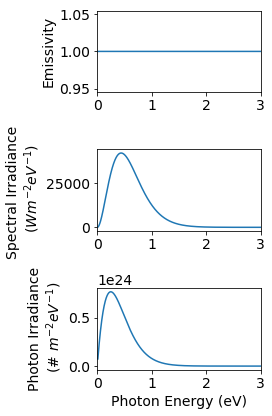

In [132]:
plots.em_ir_ph_plot(BB, BB_ph, emissivity)

(0, 3)

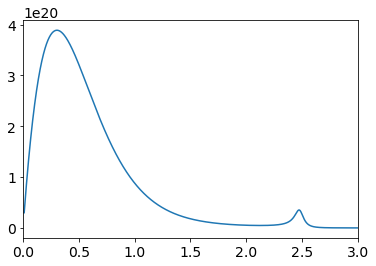

In [143]:
# Load in camera filter data 
QEdata = pd.read_csv('CamQE\\DCC3240N QE.csv', names = ['QE', 'Wavelength'])

filt_wl = 1240/500
fwhm = 5 #nm
evmin = 1240/(500+fwhm)
evmax = 1240/(500-fwhm)
fwhm_ev = evmax-evmin
filt = bb.lorentzian(0,1,filt_wl,fwhm_ev,E_ph)
BB_ph_filt = filt*BB_ph

plt.plot(E_ph, BB_ph_filt)
plt.xlim(0,3)

(0, 3)

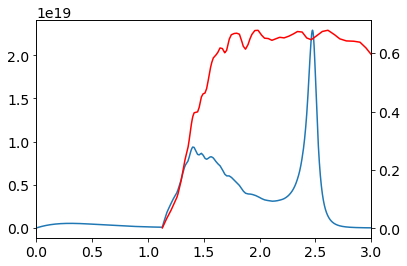

In [144]:
#Load in camera QE data

QEdata = pd.read_csv('CamQE\\DCC3240N QE.csv', names = ['QE', 'Wavelength'])
ev = 1240/QEdata['Wavelength']
ev = np.flip(ev,0)
QE = QEdata['QE']
QE = np.flip(QE,0)
QE_interp = np.interp(BB_ph_filt.index,ev,QE)
ev_interp = np.interp(BB_ph_filt.index,ev,ev)
absorbed = QE_interp*BB_ph_filt

fig, ax = plt.subplots(1)
ax.plot(absorbed)
ax2 = ax.twinx()
ax2.plot(ev_interp,QE_interp, color = 'red')
#plt.plot(absorbed)
#plt.plot(ev_interp,QE_interp)
plt.xlim(0,3)
#plt.plot(QE_interp)

In [137]:
len(QE)
len(BB_ph_filt)

9990

In [27]:
PAG = db.photons_above_bandgap(1.1,BB_ph)
detectorarea = (5e-6)*2
photonrate = PAG*detectorarea
qe = 1
exposuretime= 10e-3
es = qe*photonrate*exposuretime